# Create ML Dataset


The goal of this notebook is to create a dataset attractive to a machine learning model. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = '../data/NBADATA.csv'
data = pd.read_csv('../data/NBADATA.csv')

In [3]:
def create_dataset(data,ngames):
    """Using all the other information acquired above, create the datset using the relevant categories stated. 
    
     data : dataframe
         The NBADATA dataframe. 
    """
    nba_explore = pd.read_csv(dataset)
    del nba_explore['Unnamed: 0'],nba_explore['GAME_ID'],nba_explore['Date'],nba_explore['Team'],nba_explore['Home'],nba_explore['Away']
    del nba_explore['OU'],nba_explore['TOTAL']

#add some other potential columns, like efficency. 
    nba_explore['3P%'] = np.divide(nba_explore['3P'].values,nba_explore['3PA'].values) 

    nba_explore['FG%'] = np.divide(nba_explore['FG'].values,nba_explore['FGA'].values)
    nba_explore['FT%'] = np.divide(nba_explore['FT'].values,nba_explore['FTA'].values)
    nba_explore['TRB']  = nba_explore['OR'] + nba_explore['DR']

    nba_explore['AST/TO'] = np.divide(nba_explore['AST'].values,nba_explore['TO'].values)


    relevant_stats = []
    for col in nba_explore.columns:
        if col != 'PLUS_MINUS':
           # print(col + " Correlation to Outcome")
            corr = np.corrcoef(nba_explore[col],nba_explore['PLUS_MINUS'])
            #print(corr[0][1])
            if abs(corr[0][1]) < .1:
                pass
            else:
                relevant_stats.append(col)
        

    data['AST/TO'] = np.divide(data['AST'].values,data['TO'].values)
    data['3P%'] = np.divide(data['3P'].values,data['3PA'].values) 
    data['FG%'] = np.divide(data['FG'].values,data['FGA'].values)
    data['FT%'] = np.divide(data['FT'].values,data['FTA'].values)
    del data['Unnamed: 0'],data['TOTAL']
   # del data['Date']
    data = data.loc[data['GAME_ID'].values < 41300001] #genius! No playoff games now :)   
    #del data['Team'] 
    #data = pd.get_dummies(data) #sometimes option to hot tcode team, but not yet. Seems like overfitting. 
    teams = data.Team.unique() #each nba team. 
#iterate over those teams, make a rolling window
    nba_data = pd.DataFrame([])
    season_ids = []
    for i,val in enumerate(data['GAME_ID'].values):  #loop through every game
        season_ids.append(str(val)[1:3])

    data['Season_ID'] = season_ids #identify the unique seasons. 

    for team in teams:  #for each team
       # print(team)
    #get separate seasons here
        team_data = data.loc[data['Team'] == team]  #this contains the box score of every team game from 2013 to 2018.
        for season in data['Season_ID'].unique(): #this contains the box score of that team for that season. 
            #print(season)
            team_season = team_data.loc[team_data['Season_ID'] == season]
        
            stuff_to_turn_into_avgs =  relevant_stats  #['OR', 'DR', 'TOT', 'PF', 'ST', 'TO', 'BL', '3P%', 'FG%', 'FT%']
            for col in team_season.columns:
                if col in stuff_to_turn_into_avgs:
                        team_season['Rolling ' + col] = team_season[col].rolling(window=ngames).mean().shift(1)

            #split each season up here, 
                    #if col != 'PTS':
                    #    team_season['Rolling ' + col] = team_season[col].rolling(window=N_GAMES).mean().shift(1)

                        del team_season[col]
                    
            nba_data =  nba_data.append(team_season)

           # df = pd.concat([road_df,home_df],axis=1)
#reorganize the dataset. 
    nba_data_splits = nba_data.sort_values(by = ['GAME_ID', 'Home','Away'], ascending=[True, True,False])

    nba_data_splits.dropna(inplace=True)

    del nba_data_splits['FGA'], nba_data_splits['3PA'], nba_data_splits['FTA'], nba_data_splits['OR'],nba_data_splits['PF']                                                                                                                                
    del nba_data_splits['PLUS_MINUS'], nba_data_splits['OU'],nba_data_splits['Rolling SPREAD'],nba_data_splits['Season_ID']
    nba_dataset = pd.read_csv(dataset)                                                                                                               
    rolling_vals = nba_data_splits
    
    #now retrieve the spreads of all of these games. 
    spreads = pd.read_csv(dataset)
    spreads = spreads[['GAME_ID','SPREAD','Team']]
    
    test = rolling_vals.merge(spreads,on=['GAME_ID','Team'])
    test = test.sort_values(by = ['GAME_ID', 'Home','Away'], ascending=[True, True,False])

    #There will be instances where a team has played 30 games, but their opponent has only played 29 or fewer.
    #This tool right here retains only instances where the game has both opponents at this 30 game threshold, and then aligns them. 
    
    
    from collections import Counter

    counts = Counter(test['GAME_ID'].values)

    test['GAME_ID'].values
    vals = np.array(list(counts.values())) == 2
    useable_games = np.array(list(counts.keys()))[vals] 
    
    
    clunky = pd.DataFrame([])
    for col in test.columns:
        clunky[col] = test[col]  #how to assign the same columns, and values in it!

    for i, row in enumerate(clunky.values):
        if row[0] not in useable_games:
            #print(i)
           # print('invalid')
            clunky = clunky.drop(index=i)
    nba_data  = clunky
    nba_data_splits = nba_data.sort_values(by = ['GAME_ID', 'Home','Away'], ascending=[True, True,False])
    #Convert to the common box score already used. 

    road_df = nba_data_splits.iloc[::2]
    home_df = nba_data_splits.iloc[1::2]
    for col in nba_data_splits.columns:
        road_df['road_' + col] = road_df[col]
        home_df['home_' + col] = home_df[col]
    
        del road_df[col],home_df[col]

    home_df.reset_index(inplace=True)
    road_df.reset_index(inplace=True)

    #merged into a dataframe here. 
    df = pd.concat([road_df,home_df],axis=1)
    del df['index']
    
    #only retain the home flag, since we just care about the being home outcome since it aligns with home team spread
    df['Home'] = df['home_Home']
    df['GAME_ID'] = df['road_GAME_ID']
    del df['road_GAME_ID'],df['home_GAME_ID'],df['road_Date'],df['home_Date']
    del df['road_Away'],df['road_Home'],df['home_Away'],df['home_Home']
    
    data = pd.read_csv(dataset)
    data = data[['GAME_ID','PLUS_MINUS','Home']]
    
    df = df.merge(data,on=['GAME_ID','Home'])  #this is correct. #this is the +/- fp

    #remove the final extraneous columns. 

    del df['road_Team'],df['home_Team'],df['GAME_ID']
    del df['Home']
    
    
    outcome = df['PLUS_MINUS'] #df['home_SPREAD'] + df['PLUS_MINUS'] r
    
    y = []
    for val in outcome:
        if val>0: 
            y.append(1) #home team wins. 
        else:
            y.append(0)
            
    df['Home Team Won?'] = y
    
    return df


In [4]:
nba_df = create_dataset(data,20)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [5]:
nba_df.to_csv('model_ready_data.csv')

In [6]:


y = nba_df['Home Team Won?']
del nba_df['PLUS_MINUS'],nba_df['Home Team Won?']
X = nba_df

# Extra Credit!! 

Can data preprocessing prove that this problem is machine learning applicable?

By applying tsne and principal component analysis, a 2 dimensional version of this dataset is able to be visualized. While this new form of the data cannot be applied to new information and thus not useful for prediction purposes, a quick look at it now can help distinguish whether or not the two classes, winner or loser, are indeed separated enough such that a model should be capable of distinguishing between them. 

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

pca = PCA(n_components=2)

In [8]:
X_pca = pca.fit_transform(X)

y = np.array(y)

In [9]:
#corresponding labels to the processed data. 
home_team_wins_tsne = X_embedded[y == 1]
home_team_loses_tsne = X_embedded[y == 0]

home_team_wins_pca = X_pca[y == 1]
home_team_loses_pca = X_pca[y == 0]


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


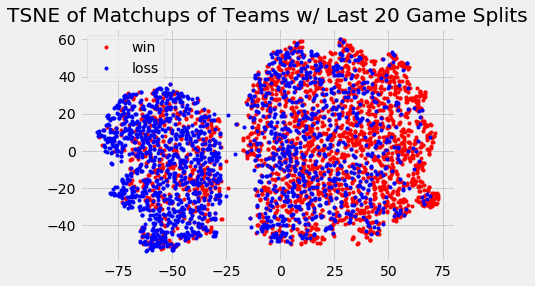

In [15]:
plt.title('TSNE of Matchups of Teams w/ Last 20 Game Splits')
plt.plot(home_team_wins_tsne[:,0],home_team_wins_tsne[:,1],'r.',label = 'win')

plt.plot(home_team_loses_tsne[:,0],home_team_loses_tsne[:,1],'b.',label = 'loss')
plt.legend()

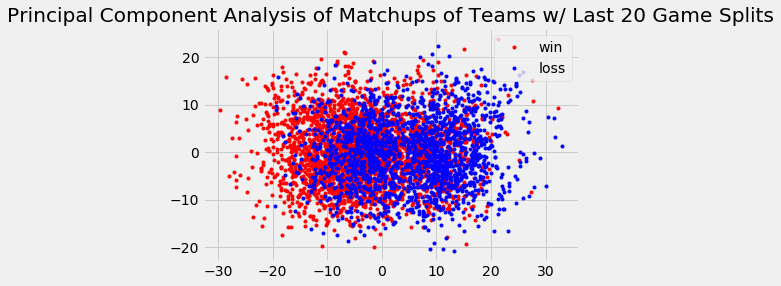

In [16]:
plt.title('Principal Component Analysis of Matchups of Teams w/ Last 20 Game Splits')
plt.plot(home_team_wins_pca[:,0],home_team_wins_pca[:,1],'r.',label = 'win')

plt.plot(home_team_loses_pca[:,0],home_team_loses_pca[:,1],'b.',label = 'loss')
plt.legend()

Both of these plots demonstrate a separation in the data. While it isn't as clean and separated as one would hope, we don't live in an ideal world and will have to see what sorts of ML models can still find a way in this data. 

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X_pca,y,shuffle=False,test_size = .25)
knn = KNeighborsClassifier(n_neighbors=50)


knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [14]:
knn.score(X_test,y_test)

0.67447916666666663